In [55]:
import numpy as np
import os
from sklearn.datasets import fetch_openml
from sklearn import preprocessing

In [56]:
A = np.random.randn(256, 2000)
B = np.random.randn(2000, 800)

# помножить каждый вектор-строку на B и сконкатенировать
%time C = np.stack(np.dot(A[i].T, B) for i in range(256))

# это то же самое, что использовать одно-большое матричное умножение
%time C = np.dot(A, B)

CPU times: user 125 ms, sys: 9.83 ms, total: 135 ms
Wall time: 67.7 ms
CPU times: user 38.3 ms, sys: 850 µs, total: 39.2 ms
Wall time: 19.6 ms


In [57]:
class Module():
    def __init__(self):
        self._train = True
    
    def forward(self, input):
        raise NotImplementedError

    def backward(self,input, grad_output):
        raise NotImplementedError
    
    def parameters(self):
        return []
    
    def grad_parameters(self):
        return []
    
    def train(self):
        self._train = True
    
    def eval(self):
        self._train = False

In [58]:
class Sequential(Module):
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)

        self.output = input
        return self.output

    def backward(self, input, grad_output):      
        for i in range(len(self.layers)-1, 0, -1):
            grad_output = self.layers[i].backward(self.layers[i-1].output, grad_output)
        
        grad_input = self.layers[0].backward(input, grad_output)
        
        return grad_input
      
    def parameters(self):
        res = []
        for l in self.layers:
            res += l.parameters()
        return res
    
    def grad_parameters(self):
        res = []
        for l in self.layers:
            res += l.grad_parameters()
        return res
    
    def train(self):
        for layer in self.layers:
            layer.train()
    
    def eval(self):
        for layer in self.layers:
            layer.eval()

In [59]:
class Linear(Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        stdv = 1./np.sqrt(dim_in)
        self.W = np.random.uniform(-stdv, stdv, size=(dim_in, dim_out))
        self.b = np.random.uniform(-stdv, stdv, size=dim_out)
        
    def forward(self, input):
        self.output = np.dot(input, self.W) + self.b
        return self.output
    
    def backward(self, input, grad_output):
        self.grad_b = np.mean(grad_output, axis=0)
        self.grad_W = np.dot(input.T, grad_output)
        grad_input = np.dot(grad_output, self.W.T)
        return grad_input
    
    def parameters(self):
        return [self.W, self.b]
    
    def grad_parameters(self):
        return [self.grad_W, self.grad_b]

In [60]:
class ReLU(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(grad_output, input > 0)
        return grad_input

У ReLU есть проблема — у него бесполезная нулевая производная при $x < 0$.

[**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs) — это его модифицированная версия, имеющая в отрицательных координатах не нулевой градиент, а просто помноженный на маленькую константу `slope`.

$$
LeakyReLU_k(x)=
\begin{cases}
x, & x > 0\\
kx, & x \leq 0\\
\end{cases}
$$

При `slope` = 0 он превращается в обычный `ReLU`. 

In [61]:
class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super().__init__()
            
        self.slope = slope
        
    def forward(self, input):
        self.output = np.maximum(input, input*self.slope)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = (input > 0) + self.slope * (input <= 0)
        return grad_input

In [62]:
class Sigmoid(Module):
    def __init__(self, slope=0.03):
        super().__init__()

    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = self.output*(1 - self.output)*grad_output
        return grad_input

In [63]:
class SoftMax(Module):
    def __init__(self):
         super().__init__()

    def forward(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))   
        esum = np.sum(np.exp(self.output), axis=1, keepdims=True)
        self.probs = np.array(np.exp(self.output)) / esum
        self.output = self.probs
        return self.output
    
    def backward(self, input, grad_output):
      grad_input = []
      for b in range(self.probs.shape[0]):
        eye = np.eye(self.probs.shape[1])
        prob_matr = np.repeat(self.probs[b].reshape(1,-1), self.probs[b].shape[0], axis=0)
        res = np.dot(grad_output[b].reshape(1,-1), prob_matr.T*(eye-prob_matr))
        grad_input.append(res)
      grad_input = np.array(grad_input).reshape(-1, self.probs[b].shape[0])
      return grad_input

In [64]:
class Criterion():        
    def forward(self, input, target):
        raise NotImplementedError

    def backward(self, input, target):
        raise NotImplementedError

In [65]:
class MSE(Criterion):
    def forward(self, input, target):
        batch_size = input.shape[0]
        self.output = np.sum(np.power(input - target, 2)) / batch_size
        return self.output
 
    def backward(self, input, target):
        self.grad_output  = (input - target) * 2 / input.shape[0]
        return self.grad_output

In [66]:
class CrossEntropy(Criterion):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target): 
        # чтобы нигде не было взятий логарифма от нуля:
        eps = 1e-9
        self.input_clamp = np.clip(input, eps, 1 - eps)
        eye = np.eye(self.input_clamp.shape[1])
        self.ohe = np.squeeze(eye[target], axis = 1)
        self.res = np.log(self.input_clamp)*self.ohe
        self.output = -np.sum(self.res, axis=1) / target.shape[0]
        return self.output

    def backward(self, input, target):
        self.grad_output = (self.input_clamp - self.ohe)/target.shape[0]
        return self.grad_output

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
def SGD(params, gradients, lr=1e-3):   

    for weights, gradient in zip(params, gradients):
        weights -= lr * gradient
        params = weights

In [69]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
      
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [70]:
n = 1000
X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n,1)
print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 26.982434847689568


In [71]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

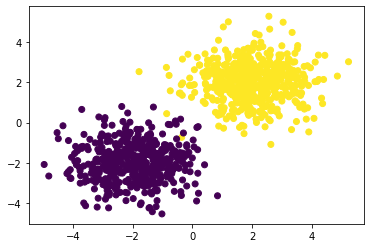

In [72]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)]).astype('int')
Y = Y.reshape(-1,1)

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [73]:
epochs = 10
batch_size = 10
learning_rate = 1e-1


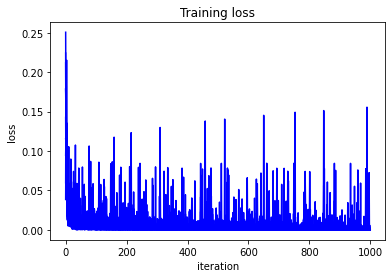

In [74]:
history = []
import time

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)

        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [75]:
mnist = fetch_openml("mnist_784")
X = mnist.data / 255.0
y = mnist.target
np.savez('mnist.npz', X=X, y=y)

In [76]:
enc = preprocessing.OneHotEncoder(sparse=False)
y = np.array(y).reshape(-1,1).astype(int)
X = X.to_numpy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, train_size=0.8)

In [77]:
X.shape

(70000, 784)

In [78]:
def accuracy(model, loader):
    total = 0
    correct = 0
    for X, y in loader:
        y_pred = model.forward(X)
        y = y.ravel()
        res = y_pred.argmax(axis=1)
        total += res.shape[0]
        correct += (res == y).sum()
    return correct / total

In [79]:
def SGD(params, gradients, lr=1e-3):
  res = []
  for i in range(len(params)):
    params[i] -= lr*gradients[i]
    return params

In [ ]:
epochs = 50
batch_size = 64
learning_rate = 1e+2

d = 28*28

model = Sequential(
    Linear(28*28, d*2),
    ReLU(),
    Linear(d*2, 10),
    SoftMax()
)

criterion = CrossEntropy()

history = []
import time
l = loader(X_train, y_train, batch_size)
for i in range(1, epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        history.append(loss)


    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [ ]:
accuracy(model,loader(X_test, y_test, batch_size))

In [ ]:
accuracy(model, X_train, y_train)